<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

# Building the Model

In [ ]:
# Imports

# Gensim Imports
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import spacy

nlp = spacy.load('en_core_web_lg')

In [ ]:
# Load in dataframe

path = './data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'

df = pd.read_csv(path)

df['brand'] = df['brand'].str.lower()  # Send brand to lower for later use.

df.sample()

In [ ]:
reviews = df['reviews.text'].values.tolist()

In [4]:
def text_to_words(words):
    for word in words:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  # Note: deacc removes punctuation

reviews_text = list(text_to_words(reviews))

print(reviews_text[0])

['order', 'of', 'them', 'and', 'one', 'of', 'the', 'item', 'is', 'bad', 'quality', 'is', 'missing', 'backup', 'spring', 'so', 'have', 'to', 'put', 'pcs', 'of', 'aluminum', 'to', 'make', 'the', 'battery', 'work']


In [5]:
# Create bigram models for word grouping.
# Note: Higher Threshold = fewer bigrams / trigrams
# NOTE: Ended up not using.

bigram_mod = Phrases(reviews_text, min_count=5, threshold=100)

In [6]:
# Make a few functions....

# Remove Stopwords now
def no_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]

# Bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): 
    
    text_list = []
    
    for sent in texts:
        doc = nlp(" ".join(sent))
        text_list.append([token.lemma_.lower() for token in doc if token.pos_ in allowed_postags])  # Tokenize / Append
    return text_list

In [7]:
rev_no_stops = no_stopwords(reviews_text)  # Remove Stop Words
# rev_bigrams = make_bigrams(rev_no_stops)   # Make bigrams

# Lemmatize reviews....
rev_lem = lemmatization(rev_no_stops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [8]:
id2word = corpora.Dictionary(rev_lem)  # Create dictionary

corpus = [id2word.doc2bow(text) for text in rev_lem]  # Send to bag of words as our corpus.

## Select Number of Topics & Fit Model

In [9]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    model_list : List of Models Used
    """
    
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=id2word,
                             num_topics=num_topics, random_state=42,
                             chunksize=125, workers=4)

        coherencemodel = CoherenceModel(model=model, dictionary=dictionary,
                                            corpus=corpus, coherence='u_mass')

        coherence_values.append({'num_topics': num_topics, 
                                 'coherence_score': coherencemodel.get_coherence()
                                })
        model_list.append(model)

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus,
                                                        start=2, limit=40, step=3)

In [17]:
# Print the coherence values. This will tell us the best number of topics

for i, cv in zip(range(len(coherence_values)), coherence_values):
    cv = list(coherence_values)[i].get('coherence_score')
    num = list(coherence_values)[i].get('num_topics')
    print(f'''===========================================
Model Index: {i} - {num} Topics''')
    print("Coherence Value", cv)

Model Index: 0 - 2 Topics
Coherence Value -2.5486647352826055
Model Index: 1 - 5 Topics
Coherence Value -2.889016407640736
Model Index: 2 - 8 Topics
Coherence Value -3.6515834385869352
Model Index: 3 - 11 Topics
Coherence Value -4.028169001388343
Model Index: 4 - 14 Topics
Coherence Value -3.8815559967653663
Model Index: 5 - 17 Topics
Coherence Value -4.489362790297851
Model Index: 6 - 20 Topics
Coherence Value -4.532975157684829
Model Index: 7 - 23 Topics
Coherence Value -4.50427222694171
Model Index: 8 - 26 Topics
Coherence Value -4.651477215909006
Model Index: 9 - 29 Topics
Coherence Value -4.758765876556246
Model Index: 10 - 32 Topics
Coherence Value -5.197418056574151
Model Index: 11 - 35 Topics
Coherence Value -5.1250828943892275
Model Index: 12 - 38 Topics
Coherence Value -5.3405476293844805


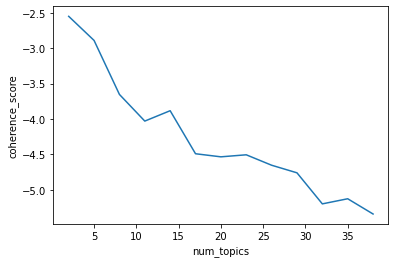

In [11]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

# Visualizations

In [12]:
# Import
import pyLDAvis.gensim

lda = model_list[4]

## Topic Distance Visualization

In [13]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.172273  0.030750       1        1  14.585643
9     -0.115932  0.196143       2        1  12.085577
2     -0.189952 -0.085592       3        1  11.886148
7     -0.078568 -0.011488       4        1   8.922304
3     -0.114827 -0.006355       5        1   7.836000
1      0.249390  0.102656       6        1   6.458990
10    -0.058111  0.099630       7        1   5.862212
8      0.198716 -0.182500       8        1   5.555845
5      0.101563  0.223704       9        1   5.375851
12    -0.131391 -0.029677      10        1   4.948669
11    -0.039910 -0.170428      11        1   4.642666
0      0.034957 -0.167409      12        1   4.550929
6      0.205322 -0.010939      13        1   3.687997
13     0.111017  0.011503      14        1   3.601172, topic_info=         Term          Freq         Total Category  logprob  loglift
19      great  10788.000000  10788.000000  Default  30.0000  30.0000
45       good   7303.000000   7303.000000  Default  29.0000  29.0000
75       love   6368.000000   6368.000000  Default  28.0000  28.0000
1480      app   3223.000000   3223.000000  Default  27.0000  27.0000
1614   screen   2934.000000   2934.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
580   problem     82.915001    788.591675  Topic14  -4.8170   1.0715
21       long     84.717003   1488.088135  Topic14  -4.7955   0.4580
19      great     87.780685  10788.156250  Topic14  -4.7599  -1.4875
17      price     83.707718   4786.403809  Topic14  -4.8075  -0.7223
13    product     73.112122   2938.122314  Topic14  -4.9428  -0.3696

[794 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
783       9  0.994045     ability
996       2  0.651548        able
996       3  0.001522        able
996       9  0.345564        able
905       3  0.951319  absolutely
...     ...       ...         ...
87       14  0.000675        year
876       5  0.137574       young
876      11  0.860879       young
2300      1  0.993599          yr
1456     10  0.884179        zone

[2101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 3, 8, 4, 2, 11, 9, 6, 13, 12, 1, 7, 14])

## Overall Model and Documents

In [14]:
distro = [lda[d] for d in corpus]

def update(doc):
    d_dist = {k:0 for k in range(0, 12)}
    for t in doc:
        d_dist[t[0]] = t[1]
    return d_dist

new_distro = [update(d) for d in distro]

In [16]:
brands = df['brand'].values.tolist()  # Send brands to list.
topic_words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]  # Get topic words
topics = [' '.join(t[0:5]) for t in topic_words]

overall_model = pd.DataFrame.from_records(new_distro, index=brands)
overall_model.columns = topics

overall_model['brand'] = overall_model.reset_index()['index'].tolist()

overall_model.groupby('brand').mean()

,good wife color far pretty,great price product beat tablet,book read child purchase use,buy internet access read picture,old year tablet buy use,app tablet great download work,work user friendly excellent connect,play game recommend video long,good screen price product clear,love easy tablet use buy,kid tablet want durable charge,good product card young daughter,daughter happy phone case size,lot expect need money cost
brand,,,,,,,,,,,,,,
amazon,0.040341,0.064338,0.093638,0.062494,0.138218,0.055747,0.029367,0.066570,0.051581,0.189020,0.063593,0.035414,0.090805,0.048700
amazonbasics,0.060729,0.146711,0.072323,0.058509,0.051303,0.036371,0.082370,0.105901,0.112042,0.045061,0.044400,0.044762,0.062653,0.094803


# Notes and Observations

- The 'Amazon' brand contains actual electronics. Especially tablets, probably due to Kindle

- I found 'play game recommend video long' interesting, because you might expect it to be heavier in Amazon due to kindles/tablets and 'play game' however I'm thinking phrases such as 'last a long time' is going to be a lot less common in these product reviews, as you do expect a tablet to last a while, but not always a charger.

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling